In [7]:
import sys
print(sys.executable)
print(sys.path)

c:\Users\N1259534\AppData\Local\anaconda3\envs\qaoa_sim\python.exe
['c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\python313.zip', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\DLLs', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim', '', 'C:\\Users\\N1259534\\AppData\\Roaming\\Python\\Python313\\site-packages', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages\\win32', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\envs\\qaoa_sim\\Lib\\site-packages\\Pythonwin']


In [1]:

import numpy as np
from itertools import combinations
import scipy
import networkx as nx
import matplotlib.pyplot as plt

from QAOA_objective import get_qaoa_objective
from utils import brute_force


In [49]:
import numba.cuda
print(numba.cuda.is_available())

False


In [2]:
#second example 

"""
import numpy as np
import itertools

 
# Given data
x1 = [-5.0000, -4.0000, -3.0000, -2.0000, -1.0000, 0.0000, 1.0000, 2.0000, 3.0000, 4.0000,
     5.0000, 6.0000, 7.0000, 8.0000, 9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000]
lmf1 = [0.0000, 0.0316, 0.0632, 0.0947, 0.1263, 0.1579, 0.1895, 0.2211, 0.2316, 0.2105,
       0.1895, 0.1684, 0.1474, 0.1263, 0.1053, 0.0842, 0.0632, 0.0421, 0.0211, 0.0000]
umf1 = [0.3753, 0.4868, 0.6065, 0.7261, 0.8353, 0.9231, 0.9802, 1.0000, 0.9802, 0.9231,
        0.8353, 0.7261, 0.6065, 0.8494, 1.0000, 0.8494, 0.5205, 0.2301, 0.0734, 0.0169]

x = x1[:5]
lmf = lmf1[:5]
umf = umf1[:5]


n = len(x)
prec = 10000
m = 4  # z precision bits

# Step 1: Calculate A, B, C, alpha, beta
beta = sum(lmf)
alpha = sum(x[i] * lmf[i] for i in range(n))
B_vec = [umf[i] - lmf[i] for i in range(n)]
A_vec = [x[i] * B_vec[i] for i in range(n)]
C_vec = [(A_vec[i] - (alpha / beta) * B_vec[i]) / prec for i in range(n)]

# QUBO variable index mapping
y_indices = [f"y_{i}" for i in range(n)]
z_indices = [f"z_{j}" for j in range(m)]
variables = y_indices + z_indices
var_index = {var: idx for idx, var in enumerate(variables)}
Q = np.zeros((len(variables), len(variables)))

# Step 2: Objective term (z * sum(C[i] * y[i]))
for i in range(n):
    for j in range(m):
        coeff = 2**(-j-1) * C_vec[i]
        idx_y = var_index[f"y_{i}"]
        idx_z = var_index[f"z_{j}"]
        Q[idx_y, idx_z] += coeff
        Q[idx_z, idx_y] += coeff  # symmetric

# Step 3: Penalty term for constraint: z * (sum B[i]*y[i] + beta) = 1
lambda_penalty = 500  # tune as needed

# Define A = sum 2^{-j} z_j and B = sum B[i] y_i + beta
# Expand (A*B - 1)^2 = A^2 * B^2 - 2*A*B + 1
# Compute each component separately and accumulate in Q

# Precompute 2^-j values
z_weights = [2**(-j-1) for j in range(m)]

# A^2 terms: z_j * z_k
for j1 in range(m):
    for j2 in range(m):
        coeff_z = z_weights[j1] * z_weights[j2]
        for i1 in range(n):
            for i2 in range(n):
                coeff = lambda_penalty * coeff_z * B_vec[i1] * B_vec[i2]
                idx1 = var_index[f"z_{j1}"]
                idx2 = var_index[f"z_{j2}"]
                idy1 = var_index[f"y_{i1}"]
                idy2 = var_index[f"y_{i2}"]
                Q[idy1, idy2] += coeff
                Q[idx1, idx2] += coeff
                Q[idy1, idx2] += coeff
                Q[idx1, idy2] += coeff

# -2AB terms
for j in range(m):
    for i in range(n):
        coeff = -2 * lambda_penalty * z_weights[j] * B_vec[i] * (sum(B_vec) + beta)
        Q[var_index[f"z_{j}"], var_index[f"y_{i}"]] += coeff
        Q[var_index[f"y_{i}"], var_index[f"z_{j}"]] += coeff

# Constant +1 term is ignored in QUBO

Q = (Q + Q.T) / 2  # ensure symmetry

print(Q.shape, Q)


   """

'\nimport numpy as np\nimport itertools\n\n \n# Given data\nx1 = [-5.0000, -4.0000, -3.0000, -2.0000, -1.0000, 0.0000, 1.0000, 2.0000, 3.0000, 4.0000,\n     5.0000, 6.0000, 7.0000, 8.0000, 9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000]\nlmf1 = [0.0000, 0.0316, 0.0632, 0.0947, 0.1263, 0.1579, 0.1895, 0.2211, 0.2316, 0.2105,\n       0.1895, 0.1684, 0.1474, 0.1263, 0.1053, 0.0842, 0.0632, 0.0421, 0.0211, 0.0000]\numf1 = [0.3753, 0.4868, 0.6065, 0.7261, 0.8353, 0.9231, 0.9802, 1.0000, 0.9802, 0.9231,\n        0.8353, 0.7261, 0.6065, 0.8494, 1.0000, 0.8494, 0.5205, 0.2301, 0.0734, 0.0169]\n\nx = x1[:5]\nlmf = lmf1[:5]\numf = umf1[:5]\n\n\nn = len(x)\nprec = 10000\nm = 4  # z precision bits\n\n# Step 1: Calculate A, B, C, alpha, beta\nbeta = sum(lmf)\nalpha = sum(x[i] * lmf[i] for i in range(n))\nB_vec = [umf[i] - lmf[i] for i in range(n)]\nA_vec = [x[i] * B_vec[i] for i in range(n)]\nC_vec = [(A_vec[i] - (alpha / beta) * B_vec[i]) / prec for i in range(n)]\n\n# QUBO variable index map

[(1.6243453636632417, (0, 1)), (-0.6117564136500754, (0, 2)), (-0.5281717522634557, (0, 3)), (-1.0729686221561705, (0, 4)), (0.8654076293246785, (1, 2)), (-2.3015386968802827, (1, 3)), (1.74481176421648, (1, 4)), (-0.7612069008951028, (2, 3)), (0.31903909605709857, (2, 4)), (-0.2493703754774101, (3, 4))]


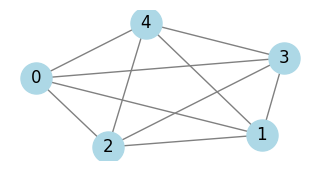

In [2]:
#Step 1: Generate terms

N = 5
np.random.seed(1)
terms = [(np.random.normal(), spin_pair) for spin_pair in combinations(range(N), r=2)]
print(terms)

# generate graph representation
G = nx.Graph()
for weight, (node1, node2) in terms:
    G.add_edge(node1, node2, wight=round(weight, 2))
    
plt.figure(figsize=(3, 1.5))
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=12)


plt.show()

In [4]:
# Step 2: get QAOA objective
# Get objective
p = 3
# for qiskit version:
# Generate the symbolic parameterized circuit
from Base.qaoa_circuit1 import get_parameterized_qaoa_circuit_from_terms
param_qc = get_parameterized_qaoa_circuit_from_terms(N, terms, p)
f = get_qaoa_objective(N, terms=terms,parameterized_circuit = param_qc,  parameterization='theta', simulator='qiskit')


#f = get_qaoa_objective(N, terms=terms, parameterization='theta', simulator='auto') #simulator='gpu', python

In [5]:
print(f)

<function get_qaoa_objective.<locals>.fq at 0x000001B75080E700>


In [6]:
# example of cost in random thetha 
theta = np.random.rand(2*p)  # or optimized params
cost = f(theta)
print(cost)

None


### Why is `cost = f(theta)` outputting `None`?

The output is `None` because the function `f` does not return a value in some cases. This usually happens if the `objective` parameter is not `'expectation'` or `'overlap'`, or if the code path in `f` does not end with a `return` statement.

#### How to fix:
- Check the implementation of `get_qaoa_objective` in `QAOA_objective.py`.
- Make sure that the inner function `f` always ends with a `return` statement for all code paths.

**Example fix:**
```python
def f(*args):
    gamma, beta = ... # parameter conversion
    result = sim.simulate_qaoa(gamma, beta, ...)
    if objective == "expectation":
        return sim.get_expectation(...)
    elif objective == "overlap":
        return 1 - sim.get_overlap(...)
    else:
        raise ValueError("Unknown objective")
```

If you miss the `return` statement, Python will return `None` by default. Double-check your function logic.

In [ ]:
# Step 3: Optimize QAOA parameters
import time
import scipy.optimize
start = time.time()
# Store cost function values during optimization

cost_values = []
def callback(xk):
    cost_values.append(f(xk))

p = 3
initial_gamma = -1*np.linspace(0, 1, p)
initial_beta = np.linspace(1, 0, p)

res = scipy.optimize.minimize(f, np.hstack([initial_gamma, initial_beta]), method='COBYLA', options={'rhobeg': 0.01}, callback=callable)
finish = time.time()
elapsed_time = finish - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [33]:
print(f"Expected QAOA solution quality: {res.fun:.5f}")

Expected QAOA solution quality: -15.15594


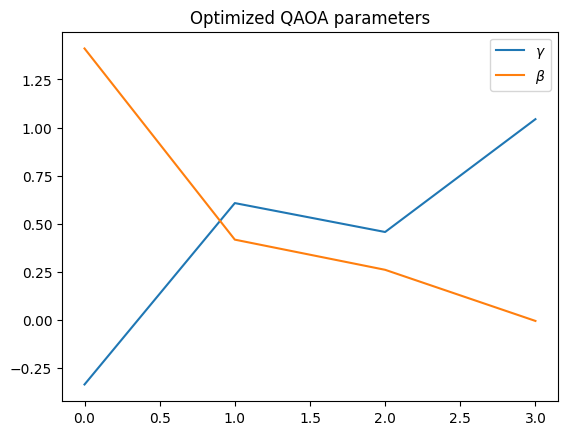

In [34]:
import matplotlib.pyplot as plt
plt.plot(-res.x[:p], label=r"$\gamma$")
plt.plot(res.x[p:], label=r"$\beta$")
plt.title('Optimized QAOA parameters')
plt.legend()

In [37]:
def f_from_terms_ground_truth(s):
    """ground truth for debugging
    """
    out = 0
    for coeff, (i, j) in terms:
        out += coeff * s[i] * s[j]
    return out


In [44]:
print(f"True minimum: {brute_force(f_from_terms_ground_truth, N, minimize=True)[0]:.5f}")

min_cost, min_bitstring = brute_force(f_from_terms_ground_truth, N, minimize=True)
qaoa_result = f(res.x)
print('True bitstring: ',min_bitstring)
print("Result from QAOA solver: ", qaoa_result)

True minimum: -20.53864
True bitstring:  [0 0 0 1 0 1 0 1 0 0]
Result from QAOA solver:  -15.15593938019446


In [46]:
#overlap = sim.get_overlap(qaoa_result)